### Neural Networks to fit $(x, y) = (\cos(\theta), \sin(\theta))$ and $\theta = \arctan2(x, y)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_circle, make_dataset_circle
from polar_coord import make_models_circle_math, make_model_circle_p2c
from polar_coord import compile_and_fit, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [-\pi, \pi]$ and $x, y \in [-1, 1]$

In [6]:
# Make datasets for circle
n = 36000
data_circle = make_data_circle(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_circle(n=n, batch_size=3600)

In [7]:
# Set number of epochs
epoch_size = n
epochs = (20000 * 3600) // n
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

# Print summary
print(f'Built data set with n={n:,}.')
print(f'Training for {epochs} epochs total, with {samples_total:,} sample points total.')
print(f'Save frequency every {save_freq:,} samples.')

Built data set with n=36,000.
Training for 2000 epochs total, with 72,000,000 sample points total.
Save frequency every 7,200,000 samples.


In [8]:
# # Unpack one example batch
# batch_theta, batch_x = list(ds_p2c.take(10))[0]
# batch_theta, batch_x = batch_theta.numpy(), batch_x.numpy()

# # Review data contents
# print(f'batch size: {batch_theta.shape[0]}')
# print(f'theta: min={np.min(batch_theta):+8.5}, max={np.max(batch_theta):+8.5}')
# print(f'    x: min={np.min(batch_x):+8.5}, max={np.max(batch_x):+8.5}')

In [9]:
theta = data_circle['theta']
x = data_circle['x']
y = data_circle['y']

## Deterministic Mathematical Models

In [10]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_models_circle_math()

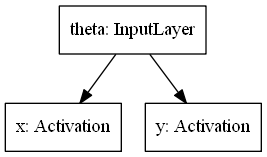

In [11]:
keras.utils.plot_model(math_p2c)

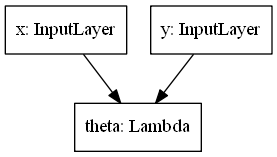

In [12]:
keras.utils.plot_model(math_c2p)

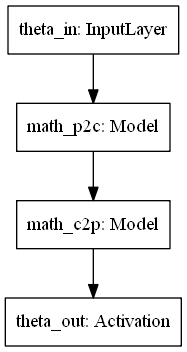

In [13]:
keras.utils.plot_model(math_p2p)

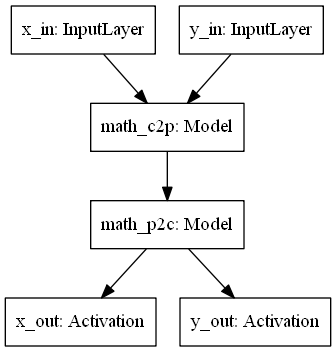

In [14]:
keras.utils.plot_model(math_c2c)

In [15]:
math_p2c.summary()

Model: "math_p2c"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (Activation)                  (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
y (Activation)                  (None, 1)            0           theta[0][0]                      
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [16]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

In [17]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [18]:
# Evaluate the p2c math model
# math_p2c.evaluate(theta, x)
math_p2c.evaluate(ds_p2c)

10/10 [==============================] - 0s 25ms/step - loss: 7.1612e-16 - x_loss: 3.7961e-16 - y_loss: 3.3651e-16 - x_mean_absolute_error: 7.6335e-09 - y_mean_absolute_error: 6.0855e-09


[7.161216547397196e-16, 3.7961065e-16, 3.36511e-16, 7.633493e-09, 6.085543e-09]

In [19]:
# Evaluate the c2p math model
# math_c2p.evaluate(x, theta)
math_c2p.evaluate(ds_c2p)

10/10 [==============================] - 0s 18ms/step - loss: 2.2487e-15 - mean_absolute_error: 1.5681e-08


[2.2486744174812755e-15, 1.5681021e-08]

In [20]:
# Evaluate the c2c math model
math_c2c.evaluate(ds_c2c)

10/10 [==============================] - 0s 41ms/step - loss: 2.5067e-15 - x_out_loss: 1.3062e-15 - y_out_loss: 1.2005e-15 - x_out_mean_absolute_error: 1.6146e-08 - y_out_mean_absolute_error: 1.3262e-08


[2.5066965562585204e-15,
 1.3061657e-15,
 1.2005308e-15,
 1.6146195e-08,
 1.3261726e-08]

In [21]:
# Evaluate the p2p math model
math_p2p.evaluate(ds_p2p)

10/10 [==============================] - 0s 15ms/step - loss: 1.5395e-15 - mean_absolute_error: 1.2495e-08


[1.539464572766975e-15, 1.2494802e-08]

## Functions for visualizing neural network outputs $x = \cos(\theta)$

In [22]:
def plot_pred_xy(model, theta):
    # Predictions of the model
    x_pred, y_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    y_pred = y_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$(x, y) = (\\cos(\\theta), \\sin(\\theta))$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$x$ and $y$')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9))
    ax.set_xticklabels(['$-\pi$', '-$3\pi/4$', '-$\pi/2$', '$-\pi/4$' ,
                        '$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, x, color='blue', label='$\cos(\\theta)$', linewidth=4.0)
    ax.plot(theta, x_pred, color='red', label='NN_x$(\\theta)$', linewidth=2.0)
    ax.plot(theta, y, color='green', label='$\sin(\\theta)$', linewidth=4.0)
    ax.plot(theta, y_pred, color='orange', label='NN_y$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [23]:
def plot_error_xy(model, theta):
    # Predictions of the model
    x_pred, y_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    y_pred = y_pred.reshape((-1,))
    
    # Errors
    x_error = x_pred - np.cos(theta)
    y_error = y_pred - np.sin(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $(x, y) = (\\cos(\\theta), \\sin(\\theta))$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$x$ and $y$')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9))
    ax.set_xticklabels(['$-\pi$', '-$3\pi/4$', '-$\pi/2$', '$-\pi/4$' ,
                        '$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(theta, x_error, color='red',  label='error_x', linewidth=4.0)
    ax.plot(theta, y_error, color='blue', label='error_y', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

## Neural networks for $x = \cos(\theta)$

### Network Design 0: [ ]
model_circle_p2c has only feature augmentation layers with powers of theta up to 8

In [24]:
def make_model_circle_p2c(powers, hidden_sizes, skip_layers):
    """
    Neural net model from theta to (x, y)
    INPUTS:
        powers: list of integer powers of the input in feature augmentation
        hidden_sizes: sizes of up to 2 hidden layers
        skip_layers: whether to include skip layers (copy of previous features)
    """
    # Input layer
    theta = keras.Input(shape=(1,), name='theta')

    # Number of hidden layers
    num_layers = len(hidden_sizes)

    # Feature augmentation; the selected powers
    theta_ps = []
    for p in powers:
        theta_p = keras.layers.Lambda(lambda z: tf.pow(z, p) / tf.exp(tf.math.lgamma(p+1.0)), name=f'theta_{p}')(theta)
        theta_ps.append(theta_p)
    
    # Augmented feature layer
    phi_0 = keras.layers.concatenate(inputs=theta_ps, name='phi_0')
    phi_n = phi_0

    # Dense feature layers
    
    # First hidden layer if applicable
    if num_layers > 0:
        phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)
        if skip_layers:
            phi_1 = keras.layers.concatenate(inputs=[phi_0, phi_1], name='phi_1_aug')
        phi_n = phi_1

    # Second hidden layer if applicable
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)
        if skip_layers:
            phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi_2_aug')
        phi_n = phi_2

    # Output layers
    x = keras.layers.Dense(units=1, name='x')(phi_n)
    y = keras.layers.Dense(units=1, name='y')(phi_n)

    # Wrap into a model
    model_name = f'model_circle_p2c_' + str(hidden_sizes)
    model = keras.Model(inputs=theta, outputs=[x, y], name=model_name) 
    return model

In [25]:
# Build the NN model of (x,y) = f(theta)
model_circle_p2c_ = make_model_circle_p2c(
    powers=[1,2,3,4,5,6,7,8],
    skip_layers=False,
    hidden_sizes=[])

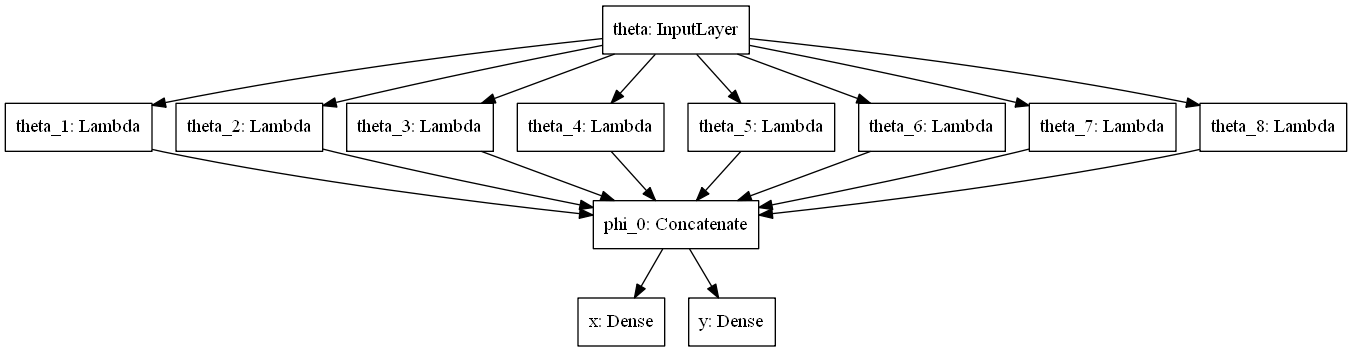

In [26]:
keras.utils.plot_model(model_circle_p2c_, show_shapes=False)

In [27]:
model_circle_p2c_.summary()

Model: "model_circle_p2c_[]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_2 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
________________________________________________________________________________

In [28]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_circle_p2c_.load_weights('../models/polar/model_circle_p2c_[].h5')
    model_circle_p2c_.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_circle_p2c_ = vartbl['hist_circle_p2c_']
    print('Loaded model_circle_p2c_.')
except:
    hist = compile_and_fit(model=model_circle_p2c_, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_circle_p2c_ = hist.history
    vartbl['hist_circle_p2c_'] = hist_circle_p2c_
    save_vartbl(vartbl, fname)

Loaded model_circle_p2c_.


In [29]:
model_circle_p2c_.evaluate(ds_p2c)

10/10 [==============================] - 1s 65ms/step - loss: 1.9589e-05 - x_loss: 4.9023e-06 - y_loss: 1.4686e-05 - x_mean_absolute_error: 0.0019 - y_mean_absolute_error: 0.0031


[1.9588714349083602e-05,
 4.902307e-06,
 1.4686407e-05,
 0.0019248778,
 0.0030548943]

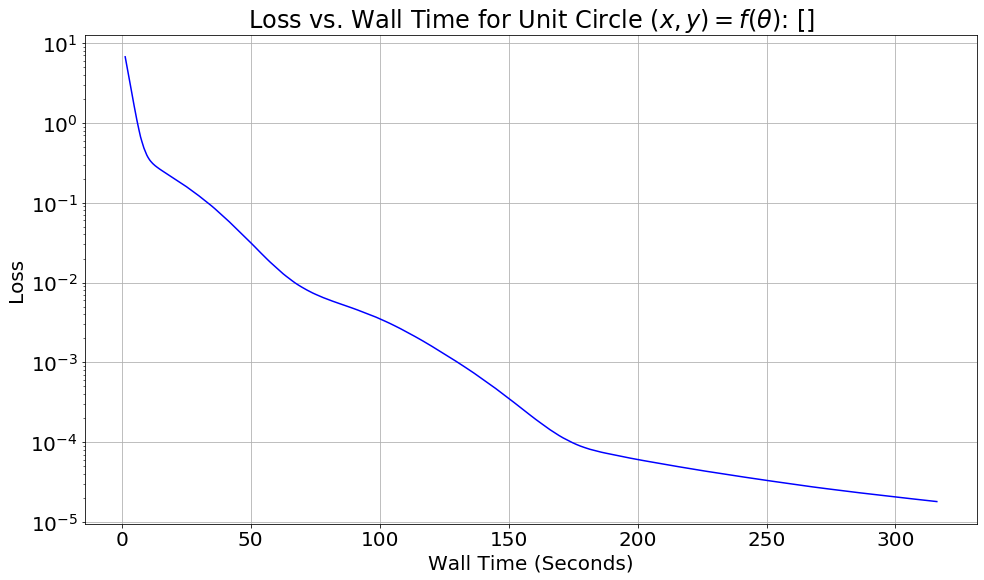

In [30]:
fig, ax = plot_loss_hist(hist_circle_p2c_, 'Unit Circle $(x, y) = f(\\theta)$: []')

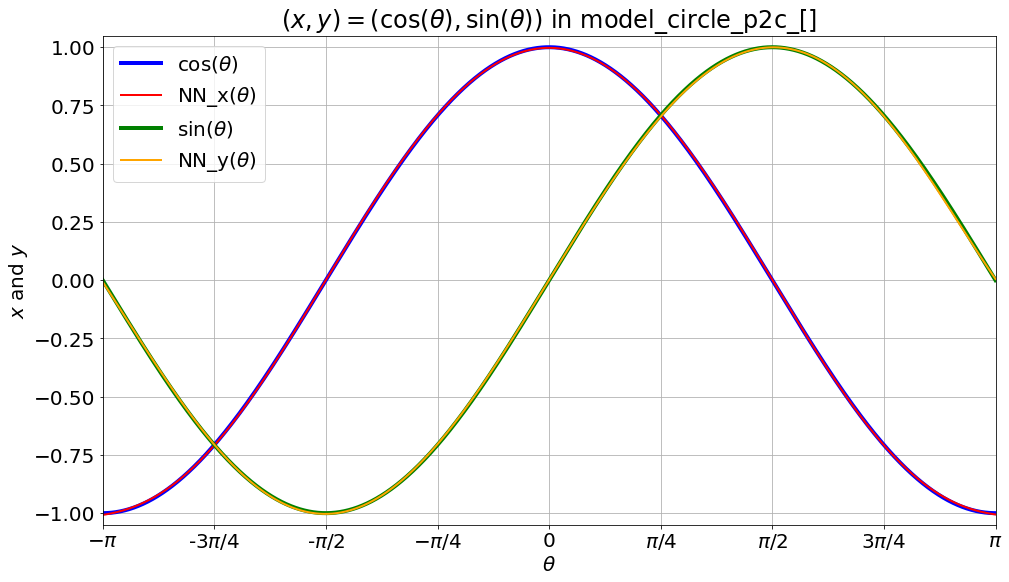

In [31]:
fig, ax = plot_pred_xy(model_circle_p2c_, theta)

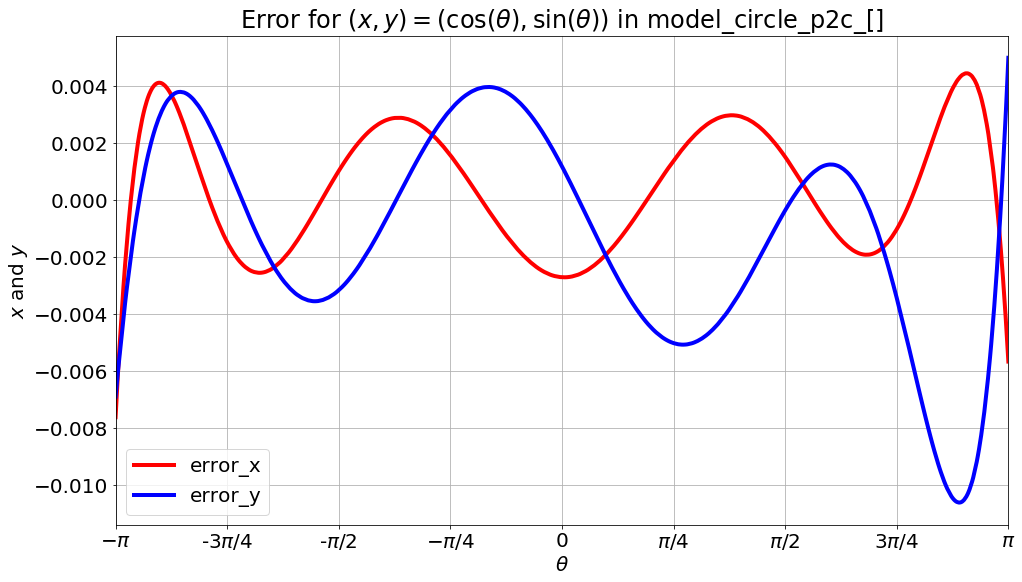

In [32]:
fig, ax = plot_error_xy(model_circle_p2c_, theta)

### Network Design 1: [64]
(model_cos_64 has one layer with 64 hidden units)

In [33]:
# Build the NN model of (x,y) = f(theta)
model_circle_p2c_64 = make_model_circle_p2c(
    powers=[1,2,3,4,5,6,7,8],
    skip_layers=True,
    hidden_sizes=[64])

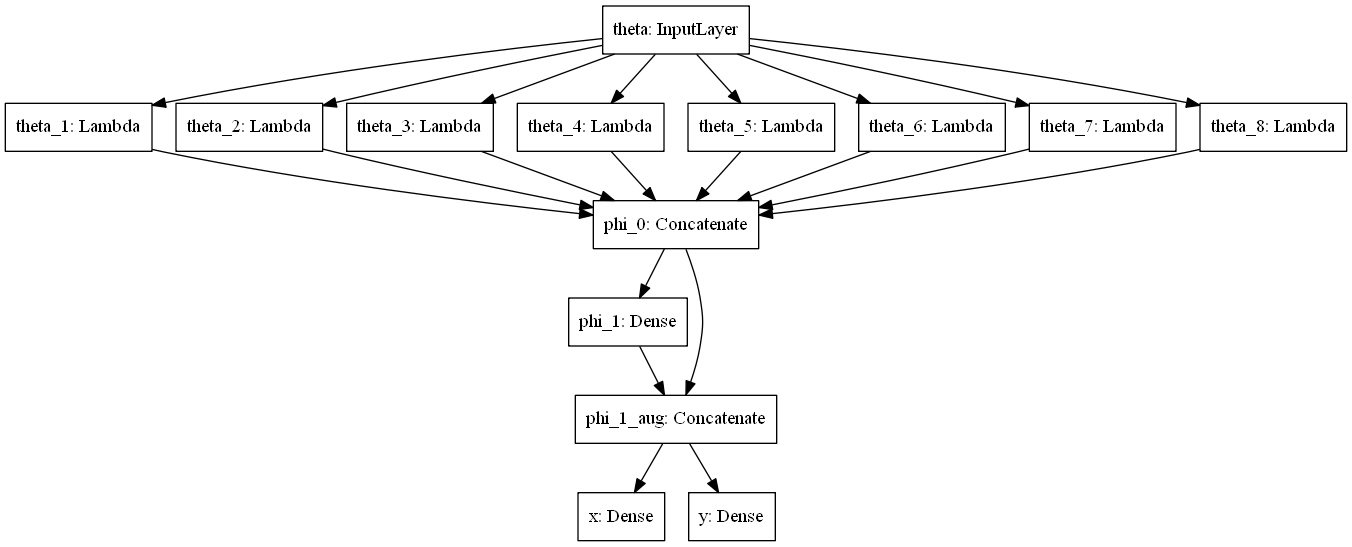

In [34]:
keras.utils.plot_model(model_circle_p2c_64, show_shapes=False)

In [35]:
model_circle_p2c_64.summary()

Model: "model_circle_p2c_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_2 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
______________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [36]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_circle_p2c_64.load_weights('../models/polar/model_circle_p2c_64[].h5')
    model_circle_p2c_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_circle_p2c_64 = vartbl['hist_circle_p2c_64']
    print('Loaded model_circle_p2c_.')
except:
    hist = compile_and_fit(model=model_circle_p2c_64, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_circle_p2c_64 = hist.history
    vartbl['hist_circle_p2c_64'] = hist_circle_p2c_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 2.90e+00; elapsed 0:00:01
Epoch 0100; loss 6.58e-04; elapsed 0:00:17
Epoch 0200; loss 1.77e-04; elapsed 0:00:33
Epoch 0300; loss 7.07e-05; elapsed 0:00:49
Epoch 0400; loss 2.83e-05; elapsed 0:01:05
Epoch 0500; loss 1.13e-05; elapsed 0:01:21
Epoch 0600; loss 4.83e-06; elapsed 0:01:37
Epoch 0700; loss 2.24e-06; elapsed 0:01:53
Epoch 0800; loss 2.35e-06; elapsed 0:02:09
Epoch 0900; loss 1.62e-06; elapsed 0:02:25
Epoch 1000; loss 7.37e-06; elapsed 0:02:41
Epoch 1100; loss 3.48e-06; elapsed 0:02:57
Epoch 1200; loss 9.88e-06; elapsed 0:03:13
Epoch 1300; loss 3.85e-06; elapsed 0:03:28
Restoring model weights from the end of the best epoch.
Epoch 01317: early stopping


In [37]:
model_circle_p2c_64.evaluate(ds_p2c)

10/10 [==============================] - 0s 33ms/step - loss: 1.5241e-06 - x_loss: 4.9392e-07 - y_loss: 1.0301e-06 - x_mean_absolute_error: 5.7519e-04 - y_mean_absolute_error: 8.9196e-04


[1.524057586266281e-06,
 4.9391576e-07,
 1.0301419e-06,
 0.00057518843,
 0.0008919643]

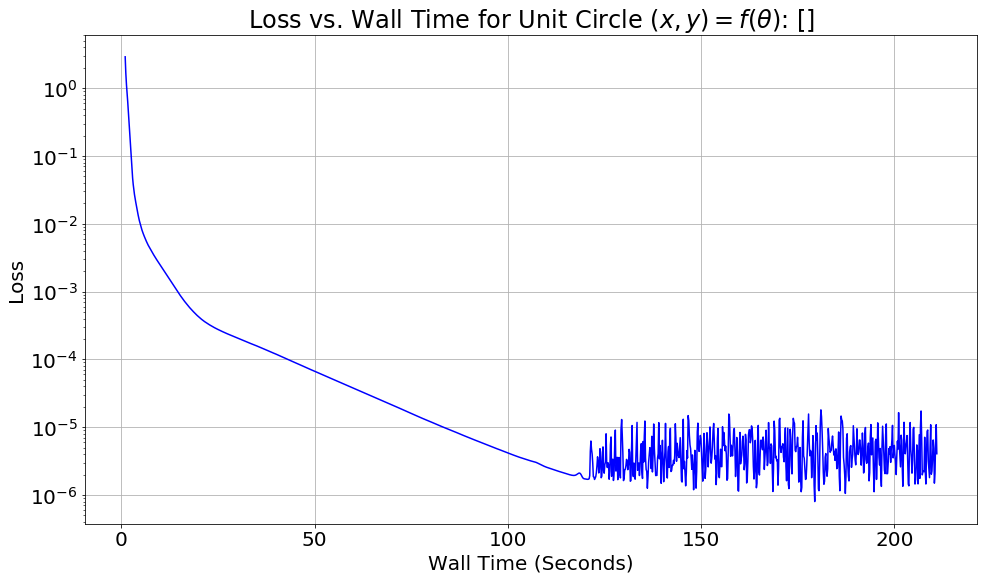

In [38]:
fig, ax = plot_loss_hist(hist_circle_p2c_64, 'Unit Circle $(x, y) = f(\\theta)$: []')

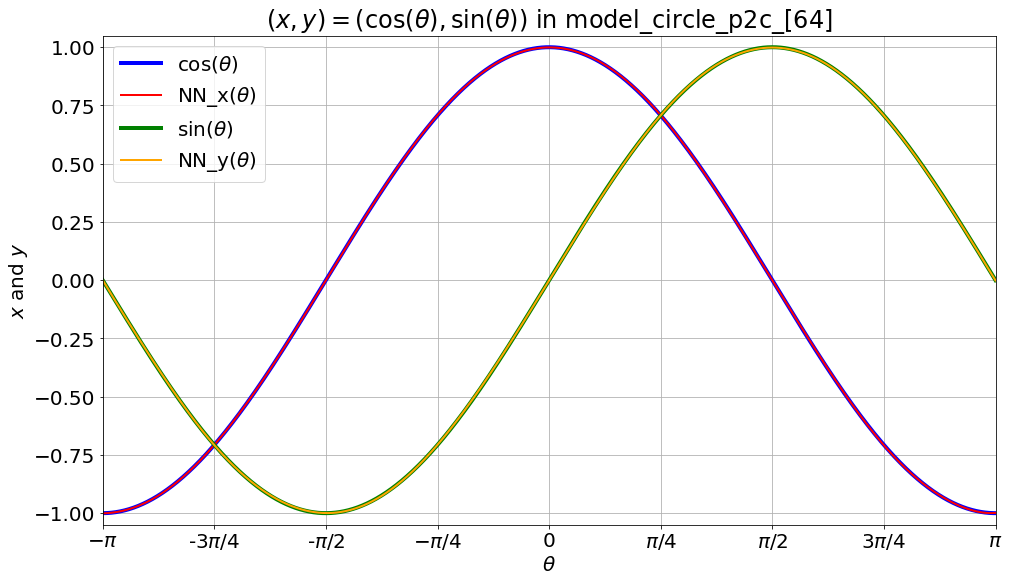

In [39]:
fig, ax = plot_pred_xy(model_circle_p2c_64, theta)

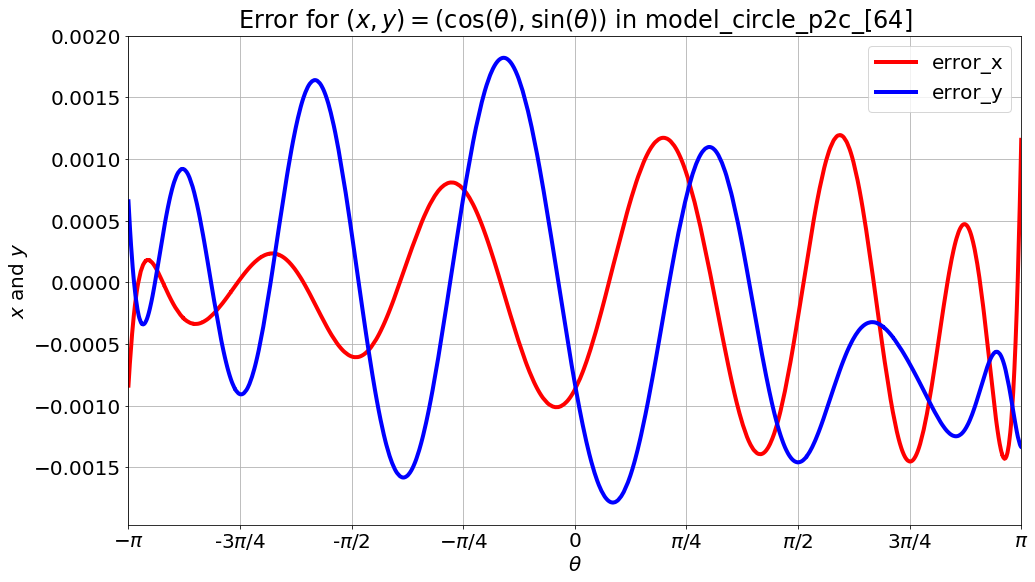

In [40]:
fig, ax = plot_error_xy(model_circle_p2c_64, theta)

### Network Design 2: [16, 16]
(model_cos_16_16 has two layers with 16 hidden units each)

In [41]:
# Build the NN model of (x,y) = f(theta)
model_circle_p2c_16_16 = make_model_circle_p2c(
    powers=[1,2,3,4,5,6,7,8],
    skip_layers=True,
    hidden_sizes=[16, 16])

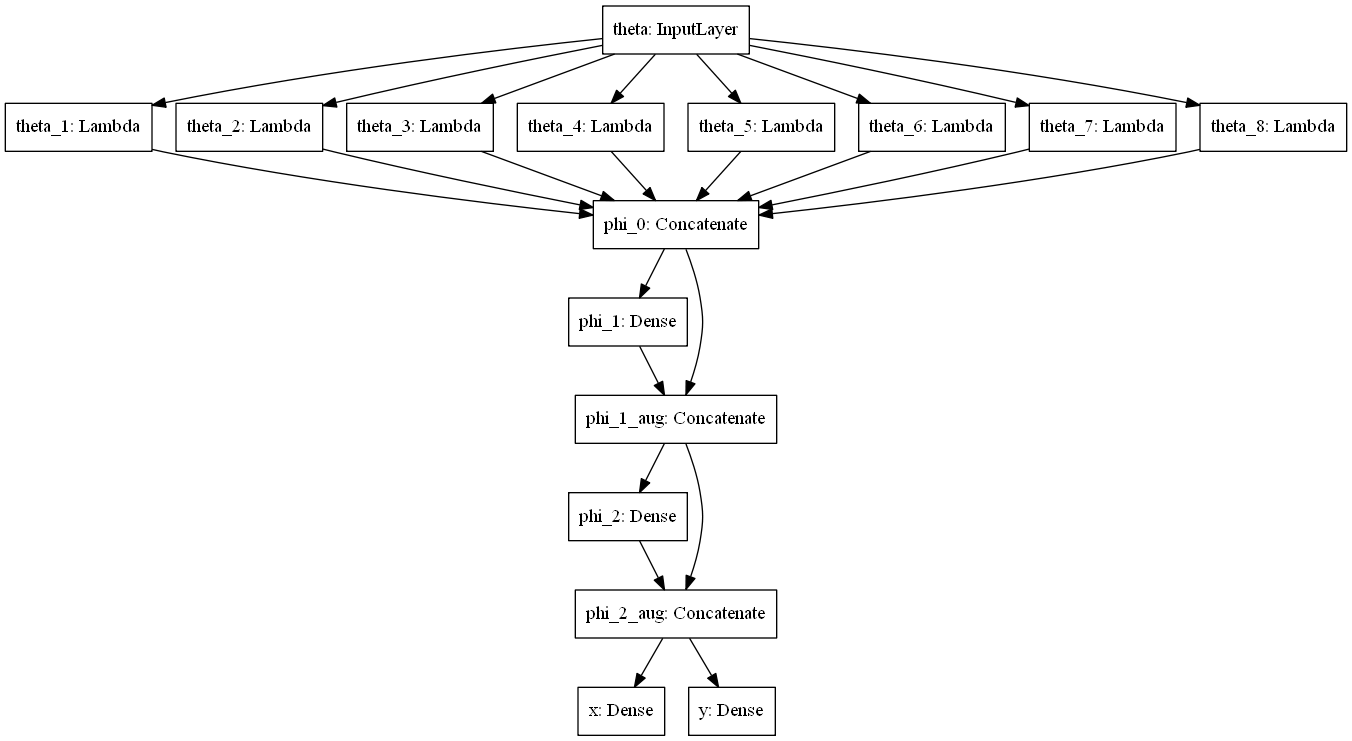

In [42]:
keras.utils.plot_model(model_circle_p2c_16_16)

In [43]:
model_circle_p2c_16_16.summary()

Model: "model_circle_p2c_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_2 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [44]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_circle_p2c_16_16.load_weights('../models/polar/model_circle_p2c_16_16[].h5')
    model_circle_p2c_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_circle_p2c_16_16 = vartbl['hist_circle_p2c_16_16']
    print('Loaded model_circle_p2c_.')
except:
    hist = compile_and_fit(model=model_circle_p2c_16_16, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_circle_p2c_16_16 = hist.history
    vartbl['hist_circle_p2c_16_16'] = hist_circle_p2c_16_16
    save_vartbl(vartbl, fname)

Epoch 0001; loss 2.45e+00; elapsed 0:00:01
Epoch 0100; loss 1.68e-04; elapsed 0:00:18
Epoch 0200; loss 3.43e-05; elapsed 0:00:35
Epoch 0300; loss 1.13e-05; elapsed 0:00:52
Epoch 0400; loss 6.05e-06; elapsed 0:01:09
Epoch 0500; loss 3.45e-06; elapsed 0:01:26
Epoch 0600; loss 1.92e-06; elapsed 0:01:43
Epoch 0700; loss 1.08e-06; elapsed 0:02:00
Epoch 0800; loss 2.19e-06; elapsed 0:02:17
Epoch 0900; loss 1.94e-06; elapsed 0:02:34
Epoch 1000; loss 1.35e-06; elapsed 0:02:50
Epoch 1100; loss 8.67e-07; elapsed 0:03:07
Epoch 1200; loss 1.11e-06; elapsed 0:03:24
Epoch 1300; loss 1.04e-06; elapsed 0:03:41
Epoch 1400; loss 3.32e-06; elapsed 0:03:57
Epoch 1500; loss 6.52e-06; elapsed 0:04:14
Restoring model weights from the end of the best epoch.
Epoch 01572: early stopping


In [45]:
model_circle_p2c_16_16.evaluate(ds_p2c)

10/10 [==============================] - 0s 35ms/step - loss: 1.0060e-06 - x_loss: 4.2646e-07 - y_loss: 5.7954e-07 - x_mean_absolute_error: 5.3648e-04 - y_mean_absolute_error: 6.5206e-04


[1.0060004001388733e-06,
 4.264577e-07,
 5.7954264e-07,
 0.0005364753,
 0.00065206306]

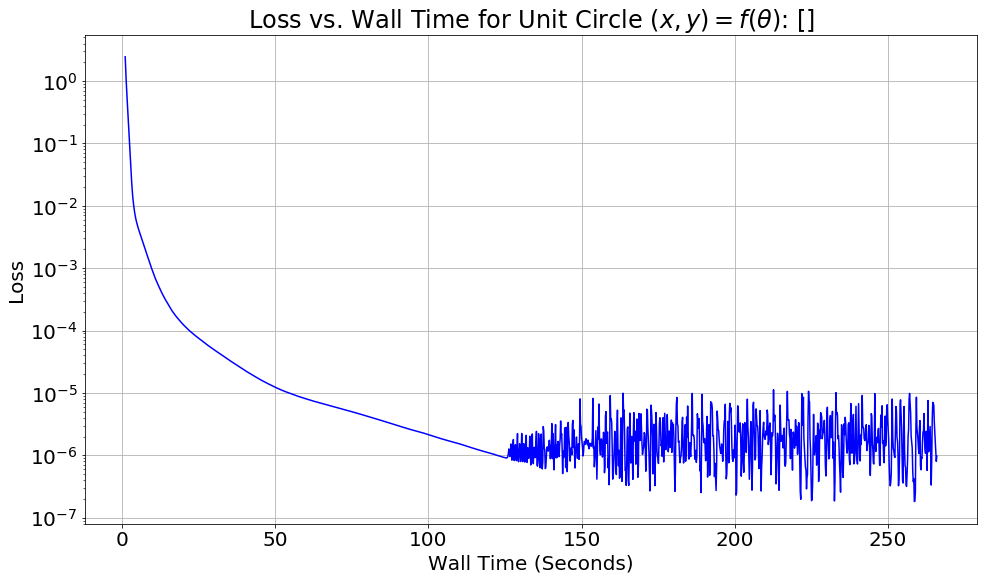

In [46]:
fig, ax = plot_loss_hist(hist_circle_p2c_16_16, 'Unit Circle $(x, y) = f(\\theta)$: []')

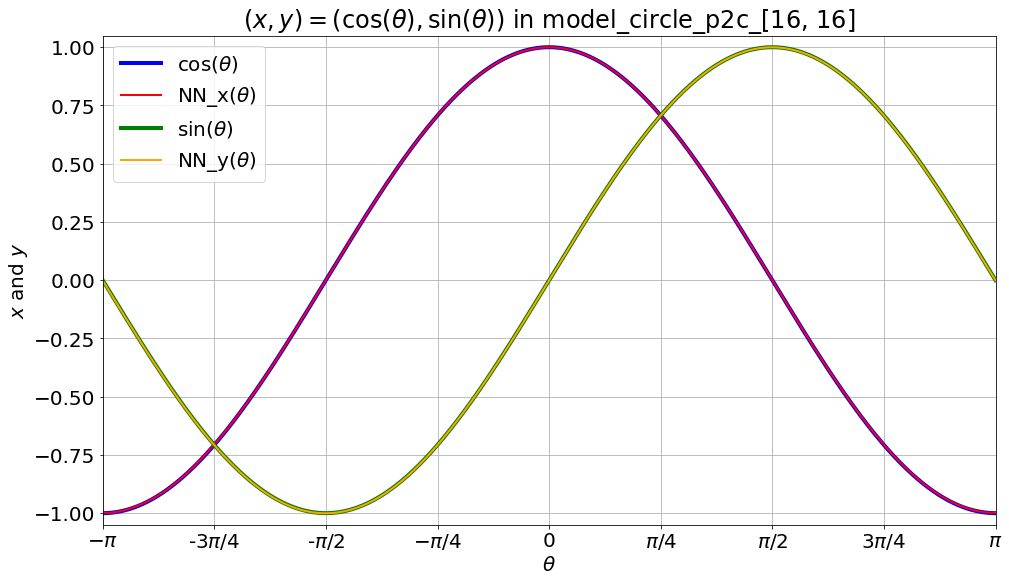

In [47]:
fig, ax = plot_pred_xy(model_circle_p2c_16_16, theta)

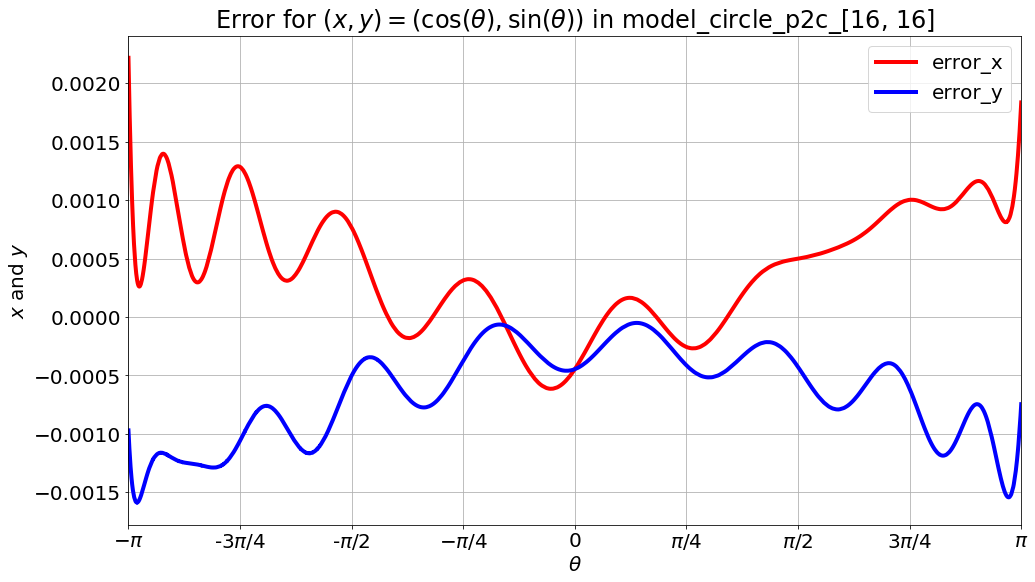

In [48]:
fig, ax = plot_error_xy(model_circle_p2c_16_16, theta)

## Neural networks for $\theta = \arg(x, y)$

## Functions for visualizing neural network outputs $\theta = \arg(x, y)$

In [80]:
def plot_pred_arg(model, x, y):
    # Predictions of the model
    theta_pred = model.predict([x, y])
    theta_pred = theta_pred.reshape((-1,))
    theta = np.arctan2(y, x)
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \arg(x, y)$ in {model.name}')
    ax.set_xlabel('$\\theta$ (true)')
    ax.set_ylabel('$\\theta$ (pred)')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9))
    ax.set_xticklabels(['$-\pi$', '-$3\pi/4$', '-$\pi/2$', '$-\pi/4$' ,
                        '$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.set_ylim(-np.pi, np.pi)
    ax.set_yticks(np.linspace(-np.pi, np.pi, 9))
    ax.set_yticklabels(['$-\pi$', '-$3\pi/4$', '-$\pi/2$', '$-\pi/4$' ,
                        '$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(theta, theta_pred, color='blue', label='$NN(\cos(\\theta), \sin(\\theta))$', linewidth=4.0)
    ax.plot(theta, theta, color='red', label='$\\theta$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [86]:
def plot_error_arg(model, x, y):
    # Predictions of the model
    theta_pred = model.predict([x, y])
    theta_pred = theta_pred.reshape((-1,))
    theta = np.arctan2(y, x)
    error = theta_pred - theta
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \arg(x, y)$ in {model.name}')
    ax.set_xlabel('$\\theta$ (true)')
    ax.set_ylabel('$\\theta$ (pred)')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9))
    ax.set_xticklabels(['$-\pi$', '-$3\pi/4$', '-$\pi/2$', '$-\pi/4$' ,
                        '$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

In [130]:
def make_model_arg(hidden_sizes, skip_layers):
    """
    Neural net model of arg function
    """
    # Input layers
    x = keras.Input(shape=(1,), name='x')
    y = keras.Input(shape=(1,), name='y')
    
    # Compute tan and cot
    tan = tf.divide(y, x, name='tan')
    cot = tf.divide(x, y, name='cot')
    
    # z/ (1+z^2) feature of tan and cot
    a0_func = lambda z : z / (1.0 + z * z)
    tan_a0 = keras.layers.Lambda(a0_func, name='tan_a0')(tan)
    cot_a0 = keras.layers.Lambda(a0_func, name='cot_a0')(cot)
    
    # z^3 / (1+z^2)^2 = (z/(1+z^2))^2 * z
    a1_func = lambda z : (z / (1.0 + z*z))**2 * z
    tan_a1 = keras.layers.Lambda(a1_func, name='tan_a1')(tan)
    cot_a1 = keras.layers.Lambda(a1_func, name='cot_a1')(cot)    
    
    # z^5 / (1+x^2)^3 = (z/(1+z^2))^3 * z^2
    a2_func = lambda z : (z / (1.0 + z*z))**3 * (z**2)
    tan_a2 = keras.layers.Lambda(a2_func, name='tan_a2')(tan)
    cot_a2 = keras.layers.Lambda(a2_func, name='cot_a2')(cot)    

    # Number of hidden layers
    num_layers = len(hidden_sizes)

    # Augmented feature layer
    phi_0 = keras.layers.concatenate([x, y, tan_a0, cot_a0, tan_a1, cot_a1, tan_a2, cot_a2], name='phi_0')
    phi_n = phi_0

    # Dense feature layers
    
    # First hidden layer if applicable
    if num_layers > 0:
        phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)
        if skip_layers:
            phi_1 = keras.layers.concatenate(inputs=[phi_0, phi_1], name='phi_1_aug')
        phi_n = phi_1

    # Second hidden layer if applicable
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)
        if skip_layers:
            phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi_2_aug')
        phi_n = phi_2

    # Third hidden layer if applicable
    if num_layers > 2:
        phi_3 = keras.layers.Dense(units=hidden_sizes[2], activation='tanh', name='phi_2')(phi_2)
        if skip_layers:
            phi_3 = keras.layers.concatenate(inputs=[phi_2, phi_3], name='phi_3_aug')
        phi_n = phi_3

    # Output layer
    theta = keras.layers.Dense(units=1, name='theta')(phi_n)

    # Wrap into a model
    model_name = f'model_arg_' + str(hidden_sizes)
    model = keras.Model(inputs=[x,y], outputs=theta, name=model_name) 
    return model

### Network Design 1: [64]

In [131]:
model_arg_64 = make_model_arg(
    hidden_sizes=[64],
    skip_layers=True)

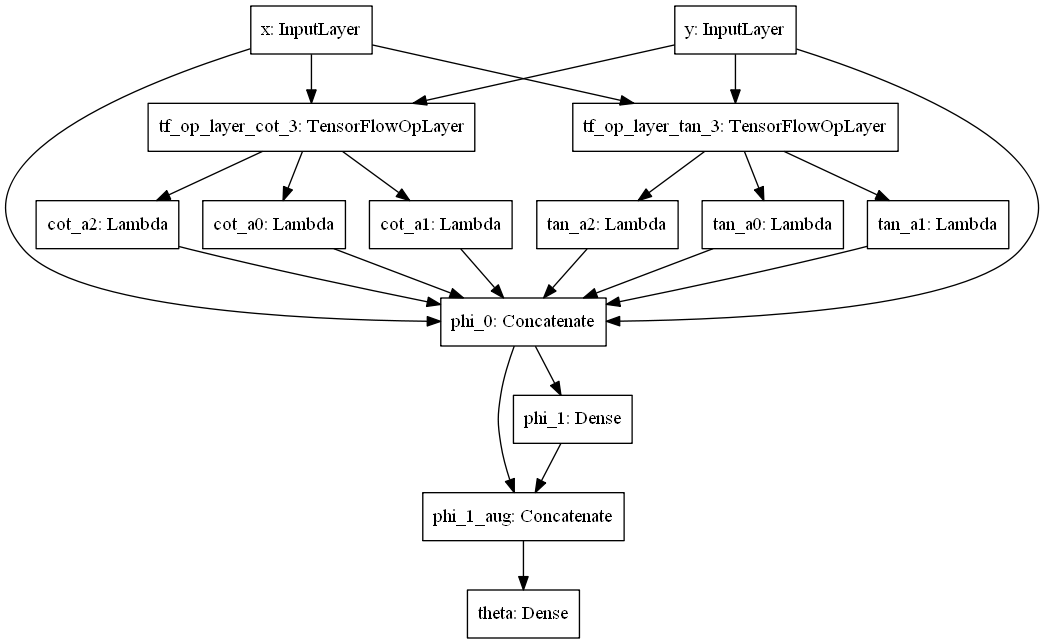

In [132]:
keras.utils.plot_model(model_arg_64)

In [133]:
model_arg_64.summary()

Model: "model_arg_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_tan_3 (TensorFlowOp [(None, 1)]          0           y[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
tf_op_layer_cot_3 (TensorFlowOp [(None, 1)]          0           x[0][0]             

In [134]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arg_64.load_weights('../models/polar/model_arg_[64].h5')
    model_arg_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arg_64 = vartbl['hist_arg_64']
    print('Loaded model_arg_64.')
except:
    hist = compile_and_fit(model=model_arg_64, 
                           ds=ds_c2p, 
                           # epochs=epochs,
                           epochs=epochs//2,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arg_64 = hist.history
    vartbl['hist_arg_64'] = hist_arg_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 2.80e+00; elapsed 0:00:01
Epoch 0050; loss 4.86e-01; elapsed 0:00:09
Epoch 0100; loss 3.00e-01; elapsed 0:00:17
Epoch 0150; loss 2.19e-01; elapsed 0:00:25
Epoch 0200; loss 1.58e-01; elapsed 0:00:33
Epoch 0250; loss 1.29e-01; elapsed 0:00:42
Epoch 0300; loss 1.09e-01; elapsed 0:00:50
Epoch 0350; loss 9.30e-02; elapsed 0:00:58
Epoch 0400; loss 8.11e-02; elapsed 0:01:07
Epoch 0450; loss 7.20e-02; elapsed 0:01:15
Epoch 0500; loss 6.48e-02; elapsed 0:01:23
Epoch 0550; loss 5.87e-02; elapsed 0:01:32
Epoch 0600; loss 5.27e-02; elapsed 0:01:40
Epoch 0650; loss 4.77e-02; elapsed 0:01:48
Epoch 0700; loss 4.40e-02; elapsed 0:01:57
Epoch 0750; loss 4.11e-02; elapsed 0:02:05
Epoch 0800; loss 3.87e-02; elapsed 0:02:13
Epoch 0850; loss 3.66e-02; elapsed 0:02:22
Epoch 0900; loss 3.47e-02; elapsed 0:02:30
Epoch 0950; loss 3.29e-02; elapsed 0:02:38
Epoch 1000; loss 3.11e-02; elapsed 0:02:46


In [135]:
model_arg_64.evaluate(ds_c2p)

10/10 [==============================] - 0s 27ms/step - loss: 0.0311 - mean_absolute_error: 0.0474


[0.031102635897696018, 0.04737663]

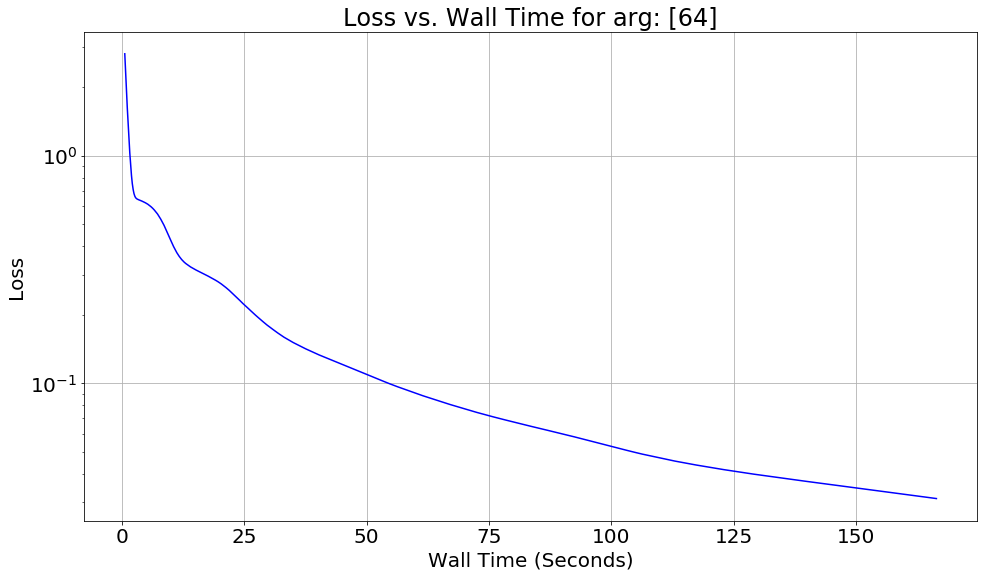

In [136]:
fig, ax = plot_loss_hist(hist_arg_64, 'arg: [64]')

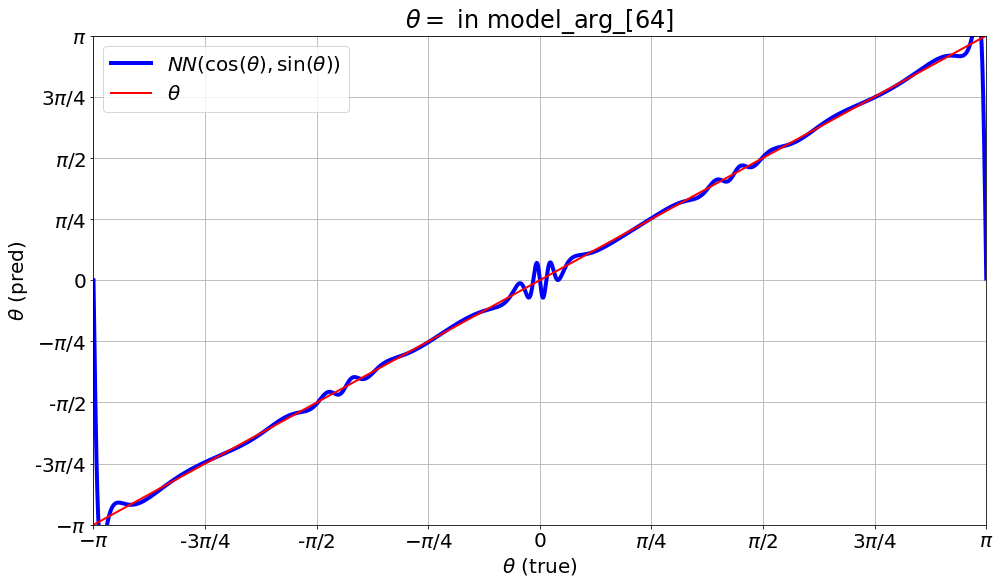

In [137]:
fig, ax = plot_pred_arg(model_arg_64, x, y)

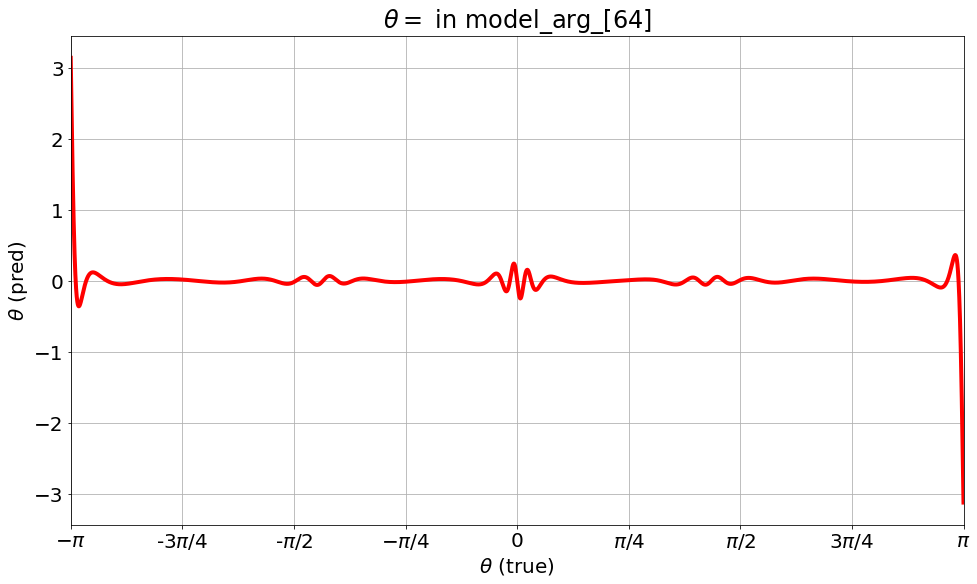

In [138]:
fig, ax = plot_error_arg(model_arg_64, x, y)

### Network Design 2: [16, 16]

In [139]:
model_arg_16_16 = make_model_arg(
    hidden_sizes=[16,16],
    skip_layers=True)

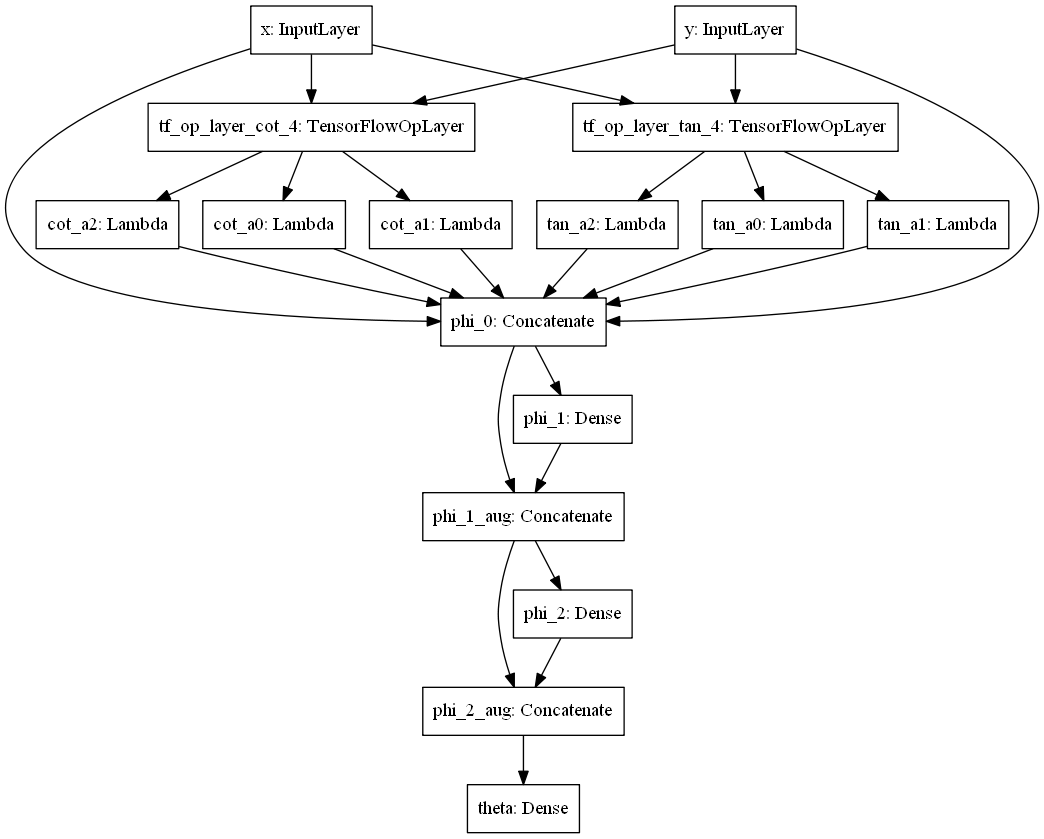

In [140]:
keras.utils.plot_model(model_arg_16_16)

In [141]:
model_arg_16_16.summary()

Model: "model_arg_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_tan_4 (TensorFlowOp [(None, 1)]          0           y[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
tf_op_layer_cot_4 (TensorFlowOp [(None, 1)]          0           x[0][0]         

In [142]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arg_16_16.load_weights('../models/polar/model_arg_[16, 16].h5')
    model_arg_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arg_16_16 = vartbl['hist_arg_16_16']
    print('Loaded model_arccos_16_16.')
except:
    hist = compile_and_fit(model=model_arg_16_16, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arg_16_16 = hist.history
    vartbl['hist_arg_16_16'] = hist_arg_16_16
    save_vartbl(vartbl, fname)

Epoch 0001; loss 1.79e+00; elapsed 0:00:01
Epoch 0100; loss 9.39e-02; elapsed 0:00:18
Epoch 0200; loss 3.83e-02; elapsed 0:00:36
Epoch 0300; loss 2.43e-02; elapsed 0:00:53
Epoch 0400; loss 1.78e-02; elapsed 0:01:10
Epoch 0500; loss 1.39e-02; elapsed 0:01:28
Epoch 0600; loss 1.11e-02; elapsed 0:01:45
Epoch 0700; loss 8.84e-03; elapsed 0:02:02
Epoch 0800; loss 7.13e-03; elapsed 0:02:20
Epoch 0900; loss 5.83e-03; elapsed 0:02:37
Epoch 1000; loss 4.85e-03; elapsed 0:02:55
Epoch 1100; loss 4.09e-03; elapsed 0:03:13
Epoch 1200; loss 3.51e-03; elapsed 0:03:30
Epoch 1300; loss 3.06e-03; elapsed 0:03:47
Epoch 1400; loss 2.70e-03; elapsed 0:04:04
Epoch 1500; loss 2.43e-03; elapsed 0:04:22
Epoch 1600; loss 2.20e-03; elapsed 0:04:39
Epoch 1700; loss 2.00e-03; elapsed 0:04:56
Epoch 1800; loss 1.83e-03; elapsed 0:05:14
Epoch 1900; loss 1.68e-03; elapsed 0:05:31
Epoch 2000; loss 1.55e-03; elapsed 0:05:49


In [144]:
model_arg_16_16.evaluate(ds_c2p)

10/10 [==============================] - 0s 15ms/step - loss: 0.0015 - mean_absolute_error: 0.0048


[0.0015217350570310372, 0.0048428746]

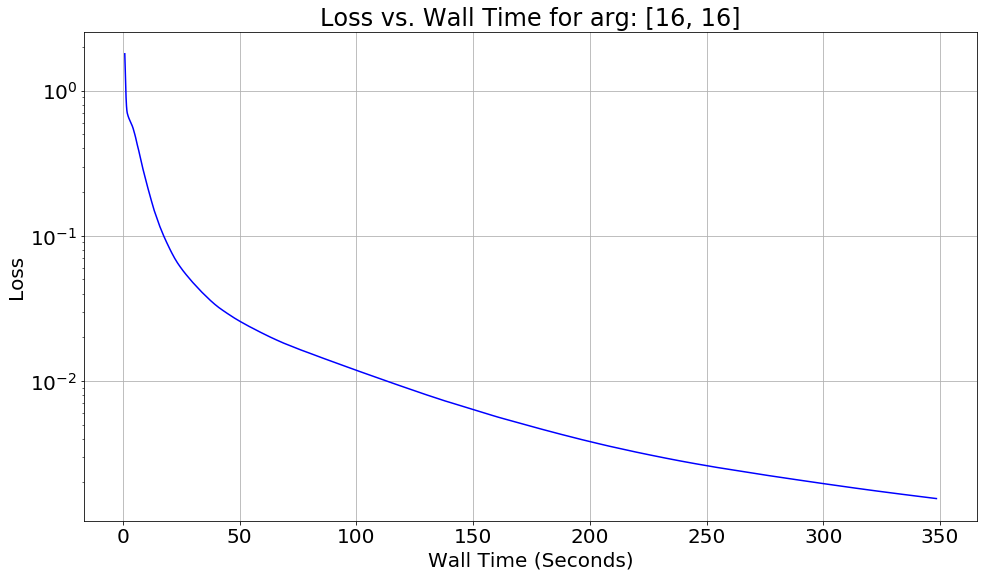

In [145]:
fig, ax = plot_loss_hist(hist_arg_16_16, 'arg: [16, 16]')

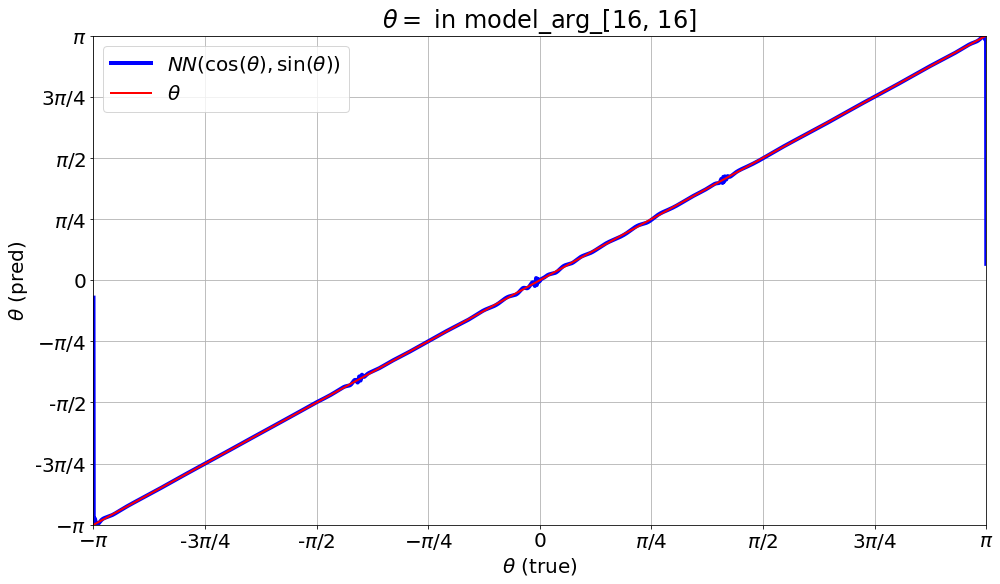

In [148]:
fig, ax = plot_pred_arg(model_arg_16_16, x, y)

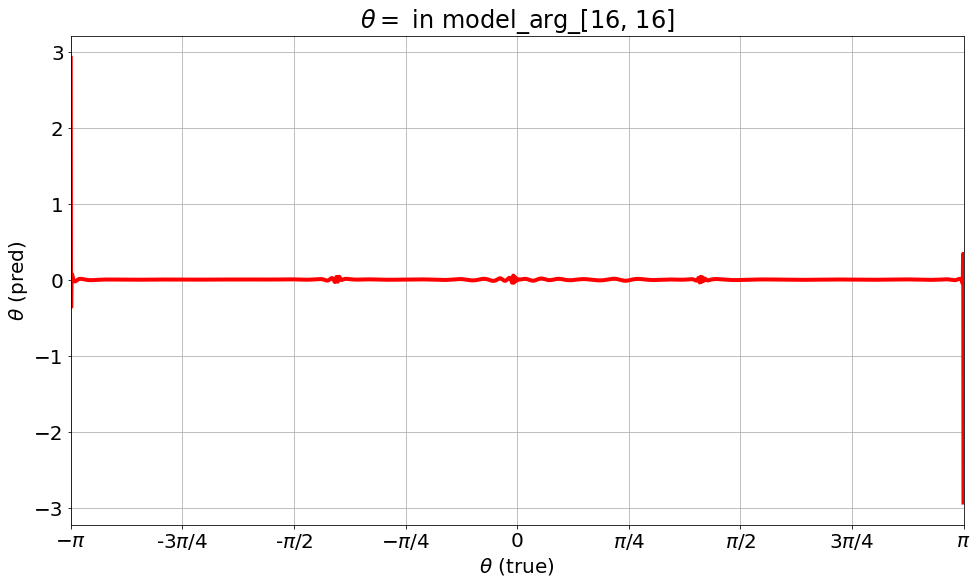

In [150]:
fig, ax = plot_error_arg(model_arg_16_16, x, y)

In [154]:
model_arg_16_16([x.reshape(-1,1), y.reshape(-1,1)])

<tf.Tensor: id=2619727, shape=(36000, 1), dtype=float32, numpy=
array([[-0.22401714],
       [-0.6500441 ],
       [-1.0591712 ],
       ...,
       [ 1.0614172 ],
       [ 0.64127696],
       [ 0.20939082]], dtype=float32)>

In [174]:
np.pi/2

1.5707963267948966

In [197]:
x = -0.9
y = -np.sqrt(1-x*x)
model_arg_16_16([np.array([[x]], dtype=np.float32), np.array([[y]], dtype=np.float32)])

<tf.Tensor: id=2622409, shape=(1, 1), dtype=float32, numpy=array([[-2.6927037]], dtype=float32)>

In [199]:
# copies of model instances
model_p2c = keras.models.clone_model(model_circle_p2c_16_16)
model_p2c.set_weights(model_circle_p2c_16_16.get_weights())
model_arg = keras.models.clone_model(model_arg_16_16)
model_arg.set_weights(model_arg_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_p2c._name = 'model_p2c'
model_arg._name = 'model_arg'